In [105]:
import numpy as np
import pandas as pd
import displacement_solver
import constitutive
import mesh_gen
import quadrature
import stress_gauss
import patch_n_int_nodes
import gauss_pt_coord
import stress_nodes_dc
import spr_stress

from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import model_from_json

In [106]:
# ............................Inputs Parameters......................#

#Doamin geometry
domain_coord = np.array([[2, 0], [20, 0], [20, 10], [0, 10], [0, 2]]);

# Body force components
b = np.array([[0], [0]])

# Traction Components
q = 1/8      #unirt force for unit length

T = np.array([[q, 0]]);

# Young's modulus
E = 1.0

# Poission's ration
nu = 1/3;

# problem type (0--->plane stress, 1---->plane strain)
problem_type = 0;

#Element type used for meshing (0---->4 nodes quadrilateral)
el_type = 0;

# No. of Gauss points required forintegration
ngp2d = 1;
ngp1d = 2;

# Number of mesh in one direction.
N = 5;

In [107]:
u = displacement_solver.solve_fem_plat_with_hole(N, E, nu, ngp2d, ngp1d, el_type, problem_type, domain_coord, b, T)
# print(u_node)

In [108]:
# ms = mesh size ----> Number of element in one direction
ms = N;

#total number of elements
nel = 2*ms*ms 

# reshaping u into u_nodes with displacement in x-direction in first column and y-direciton in second column
u_nodes = u.reshape((2*(ms+1)*(ms+1)-(ms+1), 2))
# print(u_nodes)

In [109]:
# constitutive relation matrix, calculated using the fuction "Constitutube" with input E->(Young's Modulus), nu(Poisson's raton), problem_type(plane stress or plane strain)
C = constitutive.constitutive(E, nu, problem_type)
# print(C);

In [110]:
# mesh generation 
nx = ms #number of element in x-direction
ny = ms #number of element in y-direction

# el_type = element type specifiedc. 0----> q4, q-----> q8, 2-----> q9
el_type = 0;

#mesh_obj = object created to calculated nodal coordinates ans connectivity array using functon "connectivity" and "coord_array" 
#input nx->number of element in x-direction, xy->number of element in y-direction, domain_coord->coordinates of the corner points and mid-points of the cook's skew beam problem, el_type->element type specidied.

mesh_obj = mesh_gen.platWithHole(nx, ny, domain_coord.reshape(10, 1), el_type);
connect = mesh_obj.connectivity();
# print(connect)
coord = mesh_obj.coord_array();

In [111]:
# from matplotlib import pyplot as plt
# xs = [x[0] for x in coord]
# ys = [x[1] for x in coord]
# plt.scatter(xs, ys)
# plt.show()

In [112]:
strs_ref = pd.read_csv('Data/superconv_gauss_stress_ms_256.csv')
# strs_ref = strs_ref.abs()

In [113]:
# print(strs_ref)

In [114]:
X = pd.read_csv('Coord/coord_gauss_pt_256.csv')
X = X.loc[:, ~X.columns.str.contains('Unnamed')];
y = strs_ref;
y = y.loc[:, ~y.columns.str.contains('Unnamed')];
# y = y.loc[:, ~y.columns.str.contains('x')];
# y = y.drop(columns=['x', 'y'])
# y = y.loc[:, ~y.columns.str.contains('y')];

In [115]:
# print(X.head())
# print(y.head())

In [116]:
scaler = MinMaxScaler()
scaler.fit(X)
scaled_x = scaler.transform(X)
scaled_test = scaler.transform(coord)

/home/krishna/Desktop/btp_499_code/btp_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [117]:
# print(X.head());
# print(scaled_x);
# print(scaled_test);
# print(len(scaled_x));
# print(len(scaled_test));

In [118]:
#ANN one model in whole domain for 3 output layer

model1 = Sequential()
model1.add(Dense(units=50,  activation='relu'))
model1.add(Dense(units=40, activation='relu'))
model1.add(Dense(units=30, activation='relu'))
model1.add(Dense(units=20, activation='relu'))
model1.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=3, activation='relu'))
model1.compile(
    loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))



In [119]:
 es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',  mode = 'min', verbose = 1, patience = 50);
 np.random.seed(1)
 history = model1.fit(x = scaled_x, y = y, batch_size=256, epochs=300, verbose = 1, validation_split = 0.1, callbacks= [es]);

Epoch 1/300
461/461 [==============================] - 9s 10ms/step - loss: 0.2050 - val_loss: 0.6390
Epoch 2/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0710 - val_loss: 0.2705
Epoch 3/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0700 - val_loss: 0.2348
Epoch 4/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0696 - val_loss: 0.2011
Epoch 5/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0692 - val_loss: 0.2218
Epoch 6/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0691 - val_loss: 0.1719
Epoch 7/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0689 - val_loss: 0.1691
Epoch 8/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0688 - val_loss: 0.1489
Epoch 9/300
461/461 [==============================] - 3s 7ms/step - loss: 0.0688 - val_loss: 0.1428
Epoch 10/300
461/461 [==============================] - 4s 8ms/step - loss: 0.0686 - val_l

In [120]:
var = 'x_y_xy'

In [121]:
# loss = pd.DataFrame(model1.history.history);

In [122]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('train_loss', fontsize=15)
# plt.ylabel('Loss', fontsize=15)
# plt.xlabel('Epoch', fontsize=15)
# plt.legend(['train', 'val'], loc='upper right')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.show()

In [123]:
#Saving train model with different optimizer.
# model_json = model1.to_json()
# with open('Model/model1_'+var+'.json', 'w') as json_file:
#     json_file.write(model_json)

# #serialize weights to HDF5 file
# model1.save_weights('Model/model1_'+var+'.h5')


In [124]:
# # load json and create model
json_file = open('Model/model1_x_y_xy.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json);

# #load weights into new model
loaded_model.load_weights('Model/model1_x_y_xy.h5') 

In [125]:
#Stress calculation at Gauss points
stress = np.zeros((nel, ngp2d*ngp2d, 3))
strains = np.zeros((nel, ngp2d*ngp2d, 3))

for i in range(nel):
    stress_i_g = np.zeros((ngp2d*ngp2d, 3))
    strains_i_g = np.zeros((ngp2d*ngp2d, 3))

    stress_i_g, strains_i_g = stress_gauss.get_element_stress(
        i, ngp2d, el_type, connect, coord, u, C)

    stress[i][:][:] = stress_i_g
    strains[i][:][:] = strains_i_g.reshape((1, 3))


In [126]:
# calcuation of gauss coordinates.
gauss_coords = np.zeros((nel, ngp2d*ngp2d, 2))
gp, weights = quadrature.quadrature(ngp2d)
for i in range(nel):
    node = connect[i, :]
    vertex_coord = coord[node, :].reshape(-1)
    gauss_coords[i][:][:] = gauss_pt_coord.gauss_pts(
        ngp2d, vertex_coord, gp, el_type)
gauss_coords = gauss_coords.reshape(gauss_coords.shape[0], -1)


In [127]:
#creation of patches for spr_stress;
patch, n_patches, int_nodes = patch_n_int_nodes.patch_n_int_nodes_plat_with_hole(ms)


In [128]:
#spr_stress STRESS Calculations
stress_spr = spr_stress.spr_plat_with_hole(gauss_coords, coord, connect, stress,
                     int_nodes, n_patches, patch, ms)
# stress_spr


In [129]:
#Directly calculated stress
stress_dc, strain_dc = stress_nodes_dc.stress_dc(
    connect, coord, u, nel, el_type, C);


In [130]:
#outter points in
sp = []
# print(ms)
# ms = 4
temp = ms+1
for i in range(2*ms-1):
    sp.append(temp)
    sp.append(temp+ms)
    temp = temp+ms+1
for i in range(ms+1):
    sp.append(temp)
    temp = temp+1

for i in range(ms+1):
    sp.append(i)

sp = sorted(sp)
# print(sp);

In [131]:
coord_corner = coord[sp]
# print(coord_corner)

In [132]:
scaled_test_corner = scaler.transform(coord_corner)
# scaled_test_corner

/home/krishna/Desktop/btp_499_code/btp_env/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [133]:
ref_stress = pd.read_csv('ref_stress/ref_stress_for_ms_5_from_320.csv');
ref_stress = ref_stress.loc[:, ~ref_stress.columns.str.contains('^Unnamed')];
ref_stress = ref_stress.drop(columns=['x', 'y'])
# print(ref_stress)

ref_stress = ref_stress.to_numpy();
# ref_stress

In [134]:
a = ref_stress.T
# print(len(a));

In [135]:
b = stress_spr.T
# print(len(b))

In [136]:
err_spr_abs = np.abs((a-b));
err_spr_perc = np.abs((a-b)/a);
err_dc_abs = np.abs((a-stress_dc.T));
err_dc_perc = np.abs((a-stress_dc.T)/a);
# err_spr_abs
# err_dc_abs

In [137]:
test = pd.DataFrame(scaled_test, columns =['a', 'b']);
# test

In [138]:
c = loaded_model.predict(test);
# len(c)

3/3 [==============================] - 0s 5ms/step


In [139]:
err_ann_abs = np.abs((a-c.T))
err_ann_perc = np.abs((a-c.T)/a)
# err_ann_abs

In [140]:

alll = np.concatenate([coord, 
                        a.reshape(a.T.shape[0], 3), 
                        b.reshape(b.T.shape[0], 3), 
                        c.reshape(c.shape[0], 3), 
                        err_spr_abs.reshape(err_spr_abs.T.shape[0], 3), 
                        err_ann_abs.reshape(err_ann_abs.T.shape[0],3), 
                        err_dc_abs.reshape(err_dc_abs.T.shape[0],3),
                        err_spr_perc.reshape(err_spr_perc.T.shape[0],3),
                        err_ann_perc.reshape(err_ann_perc.T.shape[0],3),
                        err_dc_perc.reshape(err_dc_perc.T.shape[0],3) 
                        ], 
                        axis = 1);
# alll

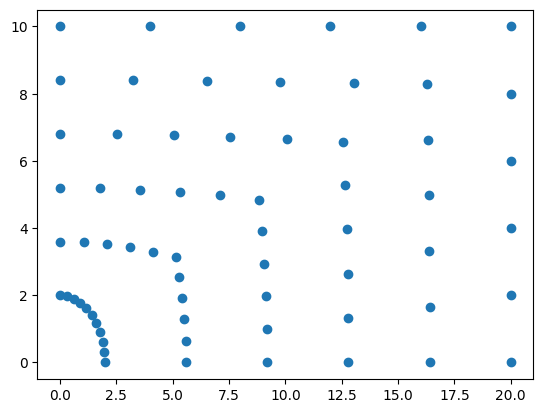

In [141]:
from matplotlib import pyplot as plt
xs = [x[0] for x in coord]
ys = [x[1] for x in coord]
plt.scatter(xs, ys)
plt.show()

In [142]:
tdf =pd.DataFrame(alll, columns=['x', 
                                'y', 
                                'ref_stress_x',
                                'ref_stress_y',
                                'ref_stress_xy', 
                                'spr_stress_x',
                                'spr_stress_y',
                                'spr_stress_xy', 
                                'ann_stress_x',
                                'ann_stress_y',
                                'ann_stress_xy', 
                                'err_spr_abs_x',
                                'err_spr_abs_y',
                                'err_spr_abs_xy', 
                                'err_ann_abs_x',
                                'err_ann_abs_y',
                                'err_ann_abs_xy', 
                                'err_dc_abs_x',
                                'err_dc_abs_y',
                                'err_dc_abs_xy',
                                'err_spr_perc_x',
                                'err_spr_perc_y',
                                'err_spr_perc_xy', 
                                'err_ann_perc_x',
                                'err_ann_perc_y',
                                'err_ann_perc_xy', 
                                'err_dc_perc_x',
                                'err_dc_perc_y',
                                'err_dc_perc_xy'
                                ]);
print(tdf);

               x     y  ref_stress_x  ref_stress_y  ref_stress_xy  \
0   2.000000e+00   0.0     -0.010481  9.569092e-01       1.201440   
1   5.600000e+00   0.0      1.278801  1.314046e+00       2.841037   
2   9.200000e+00   0.0     -0.034956  2.945819e+00       3.631842   
3   1.280000e+01   0.0      3.850629  3.951957e+00       1.333365   
4   1.640000e+01   0.0     -0.089738  3.151642e+00       3.707194   
..           ...   ...           ...           ...            ...   
61  9.797174e-17   3.6      0.064660  1.285945e-02       0.000012   
62  7.347881e-17   5.2     -0.628158  3.409312e-01       0.314106   
63  4.898587e-17   6.8      0.239362  1.606353e-01       0.000007   
64  2.449294e-17   8.4     -0.002644  6.027514e-07       0.000025   
65  0.000000e+00  10.0      0.000017  1.932879e-05      -0.000165   

    spr_stress_x  spr_stress_y  spr_stress_xy  ann_stress_x  ann_stress_y  \
0      -0.016217      0.013098       0.022988      0.000000           0.0   
1       0.013367 

In [143]:
tdf.to_csv('Results/all_matlab_train_model1_ref_'+var+'.csv');
tdf.head()

,x,y,ref_stress_x,ref_stress_y,ref_stress_xy,spr_stress_x,spr_stress_y,spr_stress_xy,ann_stress_x,ann_stress_y,...,err_dc_abs_xy,err_spr_perc_x,err_spr_perc_y,err_spr_perc_xy,err_ann_perc_x,err_ann_perc_y,err_ann_perc_xy,err_dc_perc_x,err_dc_perc_y,err_dc_perc_xy
0,2.0,0.0,-0.010481,0.956909,1.201440,-0.016217,0.013098,0.022988,0.000000,0.0,...,1.268801,0.547284,0.986312,0.980866,1.000000,1.373465,1.400125,258.700678,0.745740,1.056067
1,5.6,0.0,1.278801,1.314046,2.841037,0.013367,0.019995,0.039879,2.271190,0.0,...,4.614684,0.989547,0.984784,0.985963,1.396261,1.382261,0.116707,0.907602,0.987193,1.624296
2,9.2,0.0,-0.034956,2.945819,3.631842,-0.010521,0.022752,0.050993,2.883606,0.0,...,3.453235,0.699020,0.992277,0.985960,1.000000,0.205729,0.199601,77.074369,1.064391,0.950822
3,12.8,0.0,3.850629,3.951957,1.333365,0.057357,0.055431,0.039334,3.064341,0.0,...,0.483469,0.985104,0.985974,0.970500,0.199590,0.200700,1.401159,1.005498,0.975188,0.362593
4,16.4,0.0,-0.089738,3.151642,3.707194,-0.005518,0.029367,0.057235,3.130401,0.0,...,3.832258,0.938508,0.990682,0.984561,1.000000,0.203646,0.199800,30.503711,0.887006,1.033736
